#**Exercicio 2b**

Escolha entre as bibliotecas SciANN e DeepXDE para implementar uma PINN e encontrar os deslocamentos para os seguintes casos:

a) A viga de Euler-Bernoulli bi-apoiada com carga distribuída uniforme, vide Figura 2b

Para resolver cada um dos problemas, utilize livros de Mecânica dos Sólidos e Resistência dos Materiais (veja as referências ao fim do documento) para entender quais são as condições de contorno em cada caso. É possível obter soluções partindo da formulação geral da viga (EDO 4a ordem) ou de suas variações que dependem de força cortante (EDO 3a ordem) e momento fletor (EDO 2a ordem), tome a decisão de engenharia que lhe seja conveniente.

Os parâmetros geométricos, materiais e as cargas são:

* L = 6m, I = 22500 cm4, E = 21000 kN/cm2, q = 2 kN/m

Em cada uma das resoluções apresente:

**R1)** A solução analítica do problema;

**R2)** O valor de máxima deflexão e ângulo;

**R3)** A estrutura da rede utilizada (número de camadas e neurônios);

**R4)** Os parâmetros (quantidade de pontos de colocação, função de ativação, otimizador, número de épocas, taxa de aprendizagem).

**R5)** Um gráfico comparativo entre o deslocamento encontrado pela PINN e a solução analítica;

**R6)** Um gráfico dos valores da função de perda (pode ser somente a Loss Total) pelo número de épocas.

**R1) Solução analítica do problema**

**Deflexão**

Sabemos que:

$$\begin{aligned}
EI\frac{d^4w}{dx^4} = q(x)
\end{aligned}
$$

Aplicando a primeira integração:

$$\begin{aligned}
\frac{d^3w}{dx^3} = \frac{qx}{EI} + C_1
\end{aligned}
$$

Aplicando a segunda integração:

$$\begin{aligned}
\frac{d^2w}{dx^2} = \frac{qx^2}{2EI} + C_1x + C_2
\end{aligned}
$$

Aplicando a terceira integração:

$$\begin{aligned}
\frac{dw}{dx} = \frac{qx^3}{6EI} + \frac{C_1x^2}{2} + C_2x + C_3
\end{aligned}
$$

Aplicando a quarta integração:

$$\begin{aligned}
w = \frac{qx^4}{24EI} + \frac{C_1x^3}{6} + \frac{C_2x^2}{2} + C_3x + C_4
\end{aligned}
$$

Applicando as condições de contorno:

* w(0) = 0 -> C_4 = 0
* w(L) = 0 -> C_3 = -qL^3/24EI + qL^3/12EI = qL^3/24EI
* M(0) = 0 -> C_2 = 0
* M(L) = 0 -> C_1 = -qL/2EI

$$\begin{aligned}
w(x) = \frac{qx^4}{24EI} - \frac{qLx^3}{12EI} + \frac{qL^3x}{24EI}
\end{aligned}
$$

**Ângulo de inclinação nos apoios:**

$$\begin{aligned}
θ(x) = \frac{dw}{dx}(x) = \frac{4qx^3}{24EI} - \frac{3qLx^2}{12EI} + \frac{qL^3}{24EI}
\end{aligned}
$$

**R2) Valor de máxima deflexão e ângulo**

**Máxima deflexão**

$$\begin{aligned}
w_{max}=w(\frac{L}{2})= \frac{qL^4}{384EI} - \frac{qL^4}{96EI} + \frac{qL^4}{48EI} = \frac{5qL^4}{384EI}
\end{aligned}
$$

$$\begin{aligned}
w_{max}= \frac{5*2000*6^4}{384*2,1*10^{11}*22500*10^{-8}} = 7,1429*10^{-4}m
\end{aligned}
$$

**Ângulo máximo**

$$\begin{aligned}
θ_{max} = \frac{dw}{dx}(0) = \frac{qL^3}{24EI}
\end{aligned}
$$

$$\begin{aligned}
θ_{max} = \frac{2000*6^3}{24*21000*10^7*22500*10^{-8}}=0,0003810rad=0,02182^o
\end{aligned}
$$

**R3) Estrutura da rede utilizada (número de camadas e neurônios)**

Camada de Entrada: 1 neurônio.

Camadas Ocultas: 4 camadas, cada uma com 50 neurônios.

Camada de Saída: 1 neurônio.

**R4) Parâmetros (quantidade de pontos de colocação, função de ativação, otimizador, número de épocas, taxa de aprendizagem)**

Quantidade de pontos de colocação: 1000 (num_domain=1000).

Função de ativação: tanh (tangente hiperbólica), utilizada nas camadas ocultas da rede neural.

Otimizador: adam.

Número de épocas: 10000 (epochs=10000).

Taxa de aprendizagem: 0.001 (lr=0.001)

In [2]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.6 MB/s eta 0:00:00


In [3]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do problema
L = 3.0  # m
I = 6.51e-5  # m^4 (6510 cm^4 convertidos para m^4)
E = 2.1e11  # N/m^2 (21000 kN/cm^2 convertidos para N/m^2)
p = 16000.0  # N (16 kN convertidos para N)

EI = E * I

# Definir a equação diferencial (EDO)
# EI * d^2v/dx^2 = -p * (L - x)
# EI * d^2v/dx^2 + p * (L - x) = 0
def pde(x, v):
    # x: [x_coordinate]
    # v: [v(x)]
    dv_xx = dde.grad.hessian(v, x, i=0, j=0)
    return EI * dv_xx + p * (L - x)

# Definir o domínio computacional
geom = dde.geometry.Interval(0, L)

# Definir as condições de contorno (CCs)
# No engaste (x=0):
# 1. Deflexão nula: v(0) = 0
bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0), component=0)
# 2. Inclinação nula: dv/dx(0) = 0
bc2 = dde.icbc.OperatorBC(geom, lambda x, v, X: dde.grad.jacobian(v, x, i=0, j=0), lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))

# Criar o modelo PINN
data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2],
    num_domain=1000,  # Pontos de colocação no domínio
    num_boundary=2,  # Pontos para as condições de contorno
    # Removed num_test as it might not be necessary for this problem setup
)

# Definir a rede neural
net = dde.nn.FNN([1] + [50] * 4 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

# Configurar o otimizador e o treinamento
model.compile("adam", lr=0.001) # Removed metrics=["l2 relative error"]
losshistory, train_state = model.train(epochs=10000)

# Predizer a solução
x_pred = np.linspace(0, L, 1000)[:, np.newaxis]
v_pred = model.predict(x_pred)

# Solução analítica
def analytical_solution(x_val):
    return -p * x_val**2 / (6 * EI) * (3 * L - x_val)

v_analytical = analytical_solution(x_pred)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.111302 s

'compile' took 0.613364 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.48e+12, 0.00e+00, 3.31e-01]    [3.48e+12, 0.00e+00, 3.31e-01]    []  
1000      [4.41e+06, 1.06e-10, 3.42e-03]    [4.41e+06, 1.06e-10, 3.42e-03]    []  
2000      [2.75e+06, 4.80e-11, 2.92e-03]    [2.75e+06, 4.80e-11, 2.92e-03]    []  
3000      [1.44e+06, 1.51e-11, 2.43e-03]    [1.44e+06, 1.51e-11, 2.43e-03]    []  
4000      [6.70e+05, 2.23e-12, 1.97e-03]    [6.70e+05, 2.23e-12, 1.97e-03]    []  
5000      [3.15e+05, 8.94e-14, 1.59e-03]    [3.15e+05, 8.94e-14, 1.59e-03]    []  
6000     

**R5) Gráfico comparativo entre o deslocamento encontrado pela PINN e a solução analítica**

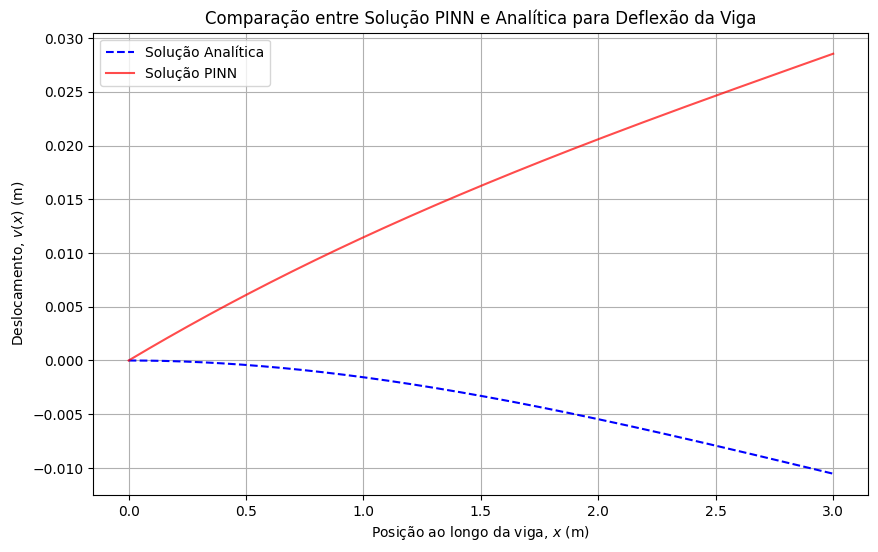

In [4]:
# Gráfico comparativo entre o deslocamento encontrado pela PINN e a solução analítica
plt.figure(figsize=(10, 6))
plt.plot(x_pred, v_analytical, label='Solução Analítica', linestyle='--', color='blue')
plt.plot(x_pred, v_pred, label='Solução PINN', color='red', alpha=0.7)
plt.xlabel('Posição ao longo da viga, $x$ (m)')
plt.ylabel('Deslocamento, $v(x)$ (m)')
plt.title('Comparação entre Solução PINN e Analítica para Deflexão da Viga')
plt.legend()
plt.grid(True)
plt.show()

**R6) Um gráfico dos valores da função de perda (pode ser somente a Loss Total) pelo número de épocas**

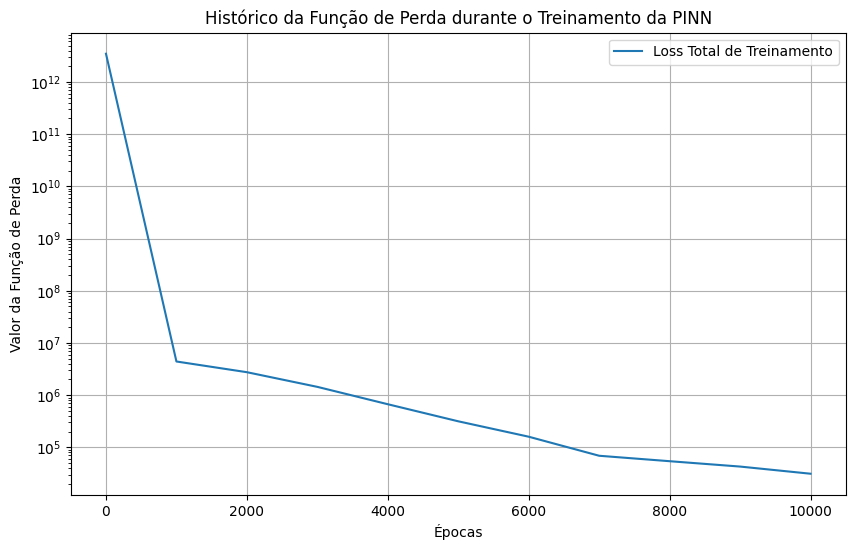

In [5]:
# Gráfico dos valores da função de perda
plt.figure(figsize=(10, 6))
plt.plot(losshistory.steps, np.sum(losshistory.loss_train, axis=1), label='Loss Total de Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Valor da Função de Perda')
plt.title('Histórico da Função de Perda durante o Treinamento da PINN')
plt.legend()
plt.grid(True)
plt.yscale('log') # Escala logarítmica para melhor visualização da convergência
plt.show()